In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os;
from misc.utils import get_mean_norm, log_to_lin, lin_to_log, generate_test_data, get_closest_values
from misc.iterators import data_iterators
from misc.MLP import MLP
from pytorch_lightning import utilities

utilities.seed.seed_everything(seed=0, workers=True)

Global seed set to 0


0

In [2]:
def load_df(datapath, datafile, which):
    if which == 'both':
        df1 = pd.read_csv(os.path.join(datapath, 'logspaced', datafile))
        df2 = pd.read_csv(os.path.join(datapath, 'linspaced', datafile))
        df = pd.concat([df1, df2], ignore_index=True)
    else:
        df = pd.read_csv(os.path.join(datapath, which, datafile))

    df = df.drop_duplicates()

    ts = df['t'].unique()
    t_10 = ts[np.argmin(np.abs(ts - 10))]
    t_max = np.max(ts)

    # print(len(df))
    df_10 = df[df['t'] == t_10].sort_values(by=['P', 'K', 'T'], ascending=True)
    df_max = df[df['t'] == t_max].sort_values(by=['P', 'K', 'T'], ascending=True)

    assert np.array_equal(df_10.values[:, :-2], df_max.values[:, :-2])

    g10 = df_10['gamma'].values
    gmax = df_max['gamma'].values

    err = np.abs((g10 - gmax) / g10) * 100

    df_10['pc_err'] = err
    df_10 = df_10.drop(['gamma', 't'], axis=1)

    idx = np.where(err > 200)[0]
    df_th = df_10.iloc[idx].sort_values(by='pc_err', ascending=True)

    print(f'Number of corrupt lines: {len(idx)}/{len(err)}')
    print(df_th)
    # print(len(df))

    # indices = []
    # for line in df_th.values:
    #     P, K, T = line[1], line[2], line[3]
    #     idx = df.loc[((df['P'] == P) & (df['K'] == K) & (df['T'] == T)), :].index
    #     indices.extend(idx.values)
    # indices = indices.un
    # print(indices)
    # print(np.max(indices), len(df))
    # df = df.iloc[indices]

    return df

dataset = 'method_0.csv'
df = load_df('datasets', dataset, 'both')

Number of corrupt lines: 88/6137
         M         P        K      T        pc_err
705862   0  1000.000  150.000  0.103  2.092978e+02
790399   0   745.015  186.254  0.103  2.541631e+02
1048656  0  1000.000  300.000  0.420  2.657186e+02
882511   0   745.015  149.003  0.103  2.868837e+02
976441   0   555.047  194.266  0.156  3.379682e+02
...     ..       ...      ...    ...           ...
992096   0  1000.000  450.000  0.314  5.553261e+11
840899   0  1000.000  350.000  0.314  5.859905e+11
1051080  0  1000.000  450.000  0.261  8.307325e+11
1131981  0  1000.000  400.000  0.314  1.368639e+12
1196823  0  1000.000  400.000  0.261  3.034714e+12

[88 rows x 5 columns]


In [3]:
def compare_with_data(P, K, T, dataset, model, include_data):
    if include_data:
        df = load_df('datasets', dataset, 'both')

        df = get_closest_values(df, P, K, T)
        df = df.sort_values(by='t', ascending=True)

        data_gam = df['gamma']
        t = df['t'].values
        X = df[['P', 'K', 'T', 't']].values
        P = df['P'].iloc[0]
        K = df['K'].iloc[0]
        T = df['T'].iloc[0]

        X = torch.tensor(X).type(torch.float)
        plt.plot(t, data_gam, label='data')

    else:
        X = generate_test_data(P, K, T)
        t = X[:, -1].clone()
        err = 0

    pred = model(X).detach().squeeze()

    if include_data:
        err = ((pred-data_gam)/data_gam).abs().mean()

    print(f"""
        P = {P}
        K = {K}
        T = {T}
    Error: {err*100:.2f}%
    """)

    plt.plot(t, pred, label='prediction')
    plt.xlabel(r'$\tau (fm)$')
    plt.ylabel(r'$d \Gamma / dK$')
    plt.legend()
    plt.show()


Number of corrupt lines: 88/6137
         M         P        K      T        pc_err
705862   0  1000.000  150.000  0.103  2.092978e+02
790399   0   745.015  186.254  0.103  2.541631e+02
1048656  0  1000.000  300.000  0.420  2.657186e+02
882511   0   745.015  149.003  0.103  2.868837e+02
976441   0   555.047  194.266  0.156  3.379682e+02
...     ..       ...      ...    ...           ...
992096   0  1000.000  450.000  0.314  5.553261e+11
840899   0  1000.000  350.000  0.314  5.859905e+11
1051080  0  1000.000  450.000  0.261  8.307325e+11
1131981  0  1000.000  400.000  0.314  1.368639e+12
1196823  0  1000.000  400.000  0.261  3.034714e+12

[88 rows x 5 columns]

        P = 745.015
        K = 223.505
        T = 0.261
    Error: 26.87%
    


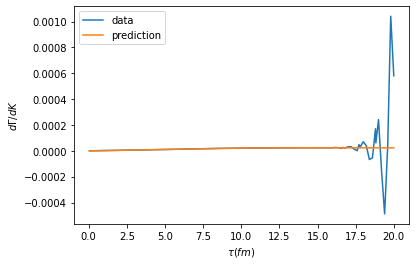

In [4]:
h_dim = 64
n_layers = 8
method = '0'
batch_size = 64
pc_err = "4.64e-02"

datafile = 'method_'+method+'.csv'

(_, _, test), consts_dict = data_iterators(
    batch_size=batch_size,
    datafile=datafile
    )

model_file = f'M_{method}_n_layers_{n_layers}_hid_dim_{h_dim}_val_pc_err={pc_err}.ckpt'
model_path = os.path.join("Results", "saved_models", f'Method_{method}', model_file)
model = MLP.load_from_checkpoint(
    checkpoint_path=model_path,
    hidden_dim=h_dim,
    n_layers=n_layers,
    consts_dict=consts_dict
    )

P = 745
K = 0.3
K *= P
T = 0.26
include_data = True

compare_with_data(P, K, T, datafile, model, include_data=include_data)

In [5]:
Ks = np.linspace(0.1, 0.9, 9, endpoint=True)
Ts =  np.linspace(0.05, 1, 10).round(3)
ts = np.logspace(np.log10(0.05), np.log10(20), 100).round(3)

# p_mean, p_norm = get_mean_norm(Ps)
T_mean, T_norm = get_mean_norm(Ts, log=False)
t_mean, t_norm = get_mean_norm(ts)

# print(p_mean, p_norm)
splits = 3
Ps = np.logspace(np.log10(5), 3, 10).round(3)
lin_spaced = np.log10(Ps)
# print(lin_spaced)
for i in range(splits):
    l2 = (lin_spaced[1:] + lin_spaced[:-1])/2
    lin_spaced = np.concatenate((lin_spaced, l2))
    lin_spaced = np.unique(lin_spaced)
    lin_spaced = np.sort(lin_spaced)
# print(lin_spaced)

# Ps = np.logspace(np.log10(5), 3, 20).round(3)
# print(Ps)
# print(log_to_lin(Ps, p_mean, p_norm))
# print(lin_to_log(log_to_lin(Ps, p_mean, p_norm), p_mean, p_norm))
# print(ts)